<a href="https://colab.research.google.com/github/szymonbiczyk/Pneumonia-detection/blob/main/Pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os, shutil, pathlib
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
from tensorflow.keras.utils import image_dataset_from_directory


In [ ]:
drive.mount('/content/drive')
!ls drive/MyDrive/Pneumonia2/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test  train  val


# Creating datasets


In [ ]:
base_dir=pathlib.Path("drive/MyDrive/Pneumonia2") 

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir / "val",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4220 files belonging to 2 classes.
Found 748 files belonging to 2 classes.
Found 888 files belonging to 2 classes.


Zliczanie rekordów odpowiadającym zapaleniu płóc i zdrowych płóc

In [ ]:
pneumonia_count = len(os.listdir('/content/drive/MyDrive/Pneumonia2/train/PNEUMONIA'))
print(pneumonia_count)
normal_count = len(os.listdir('/content/drive/MyDrive/Pneumonia2/train/NORMAL'))
print(normal_count)

3395
825


# Data shape

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape) 
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# Data regularization

Changing img contrast

In [ ]:
change_contrast = keras.Sequential([
    layers.RandomContrast(factor = 0.5)
])

Image augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomZoom(height_factor=(-0.1, 0.2), width_factor=(-0.1, 0.2)) # range zoom/zoomout - [-10%, +20%]
])

Setting model metrics

In [ ]:
my_metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Baseline model


In [ ]:
model_dnn = Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    change_contrast,
    data_augmentation,
    
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
   
])

Due to the unequal number of cases of pneumonia and healthy lungs, weight balance correction implemented

In [ ]:
initial_bias = np.log([pneumonia_count / normal_count])
print("Initial bias: {:.5f}".format(initial_bias[0]))

train_count = normal_count + pneumonia_count
weight_for_0 = (1 / normal_count) * (train_count) / 2.0
weight_for_1 = (1 / pneumonia_count) * (train_count) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.41468
Weight for class 0: 2.56
Weight for class 1: 0.62


Callbacks

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [ ]:
model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=my_metrics)
model_dnn.build((None,180, 180, 3))
model_dnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 dense (Dense)               (None, 180, 180, 16)      64        
                                                                 
 dropout (Dropout)           (None, 180, 180, 16)      0         
                                                                 
 dense_1 (Dense)             (None, 180, 180, 32)      544       
                                                                 
 dropout_1 (Dropout)         (None, 180, 180, 32)     

Model training

In [ ]:
epochs=15
history = model_dnn.fit(
    train_dataset,
    validation_data= validation_dataset,
    epochs=epochs,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/15


132/132 [==============================] - 126s 804ms/step - loss: 2.1749 - accuracy: 0.7232 - precision: 0.9110 - recall: 0.7270 - val_loss: 2.8456 - val_accuracy: 0.4853 - val_precision: 1.0000 - val_recall: 0.0026
Epoch 2/15
132/132 [==============================] - 18s 132ms/step - loss: 0.4132 - accuracy: 0.8322 - precision: 0.9501 - recall: 0.8353 - val_loss: 2.0958 - val_accuracy: 0.4853 - val_precision: 1.0000 - val_recall: 0.0026
Epoch 3/15
132/132 [==============================] - 18s 132ms/step - loss: 0.4127 - accuracy: 0.8256 - precision: 0.9505 - recall: 0.8262 - val_loss: 1.3569 - val_accuracy: 0.4880 - val_precision: 1.0000 - val_recall: 0.0078
Epoch 4/15
132/132 [==============================] - 18s 131ms/step - loss: 0.3377 - accuracy: 0.8640 - precision: 0.9638 - recall: 0.8633 - val_loss: 1.3561 - val_accuracy: 0.4866 - val_precision: 1.0000 - val_recall: 0.0052
Epoch 5/15
132/132 [==============================] - 18s 131ms/step - loss: 0.3327 - accuracy: 0.8592

Representation of accuracy and error on the training and validation set

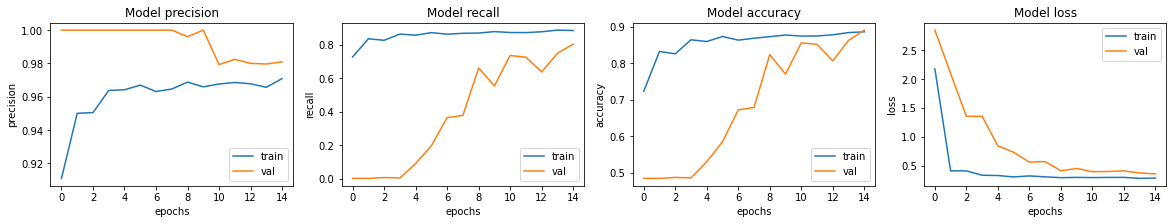

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Testing model

In [ ]:
loss, acc, prec, rec = model_dnn.evaluate(test_dataset)

28/28 [==============================] - 84s 3s/step - loss: 0.4089 - accuracy: 0.8480 - precision: 0.9085 - recall: 0.8069


#Target model


In [ ]:
model_cnn = Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)), # data rescaling [0, 255] to [0, 1]
    change_contrast,
    data_augmentation,
    
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=my_metrics)
input_shape = (None, 180, 180, 3)
model_cnn.build(input_shape)
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 89, 89, 16)        0         
                                                      

Model training

In [ ]:
epochs=15
history = model_cnn.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/15


132/132 [==============================] - 27s 132ms/step - loss: 0.6876 - accuracy: 0.6344 - precision: 0.8673 - recall: 0.6710 - val_loss: 0.5688 - val_accuracy: 0.7660 - val_precision: 0.7350 - val_recall: 0.8549
Epoch 2/15
132/132 [==============================] - 18s 129ms/step - loss: 0.3968 - accuracy: 0.8391 - precision: 0.9527 - recall: 0.8418 - val_loss: 0.4006 - val_accuracy: 0.8182 - val_precision: 0.7648 - val_recall: 0.9352
Epoch 3/15
132/132 [==============================] - 18s 130ms/step - loss: 0.3309 - accuracy: 0.8628 - precision: 0.9619 - recall: 0.8636 - val_loss: 0.2770 - val_accuracy: 0.8890 - val_precision: 0.8778 - val_recall: 0.9119
Epoch 4/15
132/132 [==============================] - 18s 130ms/step - loss: 0.2855 - accuracy: 0.8900 - precision: 0.9744 - recall: 0.8866 - val_loss: 0.2251 - val_accuracy: 0.9158 - val_precision: 0.8968 - val_recall: 0.9456
Epoch 5/15
132/132 [==============================] - 18s 130ms/step - loss: 0.2380 - accuracy: 0.9064 

Representation of accuracy and error on the training and validation set

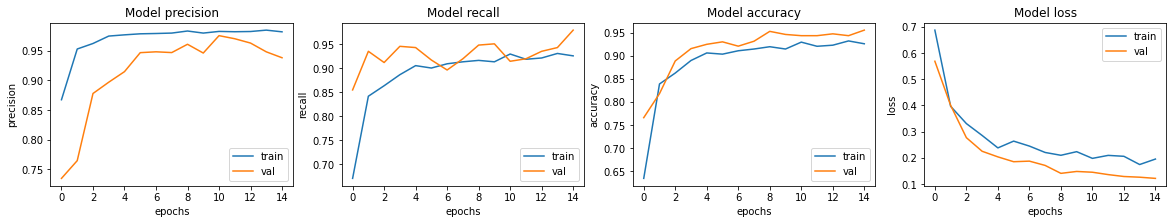

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Testing model

In [ ]:
loss, acc, prec, rec = model_cnn.evaluate(test_dataset)

28/28 [==============================] - 2s 38ms/step - loss: 0.3184 - accuracy: 0.8773 - precision: 0.8251 - recall: 0.9878
